In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment


- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [2]:
train_data = pd.read_feather('../data/train_data.ftr')

In [3]:
train_data.shape

(5531451, 191)

In [4]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [5]:
count_of_feature_type = Counter([
    x.split('_')[0] for x in train_data.columns
    if x not in ['customer_ID', 'target']
])
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=['count']).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

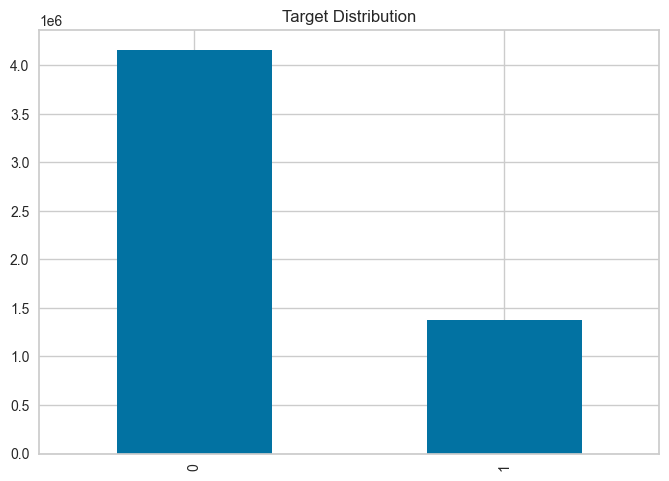

In [6]:
# calculate the percentage of training data that is 1 and 0
print(train_data['target'].value_counts(normalize=True))
train_data['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution')


In [7]:
train_data = train_data.sort_values(by=['customer_ID', 'S_2'])

In [8]:
# Extract the date information from the date column
train_data['Month'] = [i.month for i in train_data['S_2']]
train_data['Day'] = [i.day for i in train_data['S_2']]
train_data['Year'] = [i.year for i in train_data['S_2']]

In [42]:
# pick random 5000 customer_ID from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data['customer_ID'], 20000, replace=False)

In [43]:
train_rndm_sample = train_data[train_data['customer_ID'].isin(customer_ID_rand)]

0    0.761049
1    0.238951
Name: target, dtype: float64


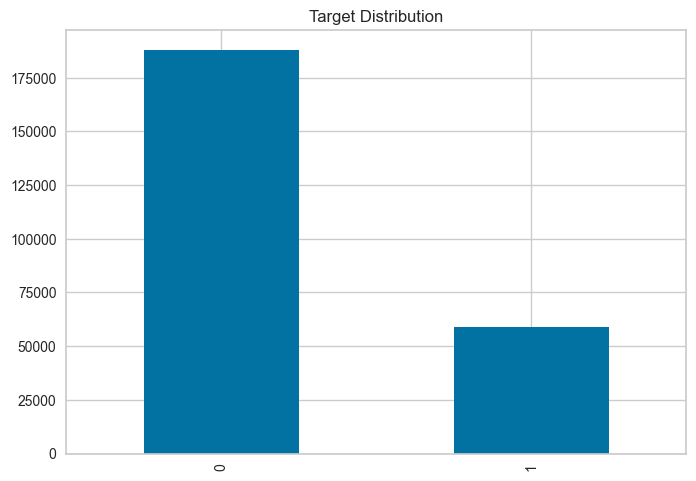

In [44]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample['target'].value_counts(normalize=True))
train_rndm_sample['target'].value_counts().plot(kind='bar',
                                         title='Target Distribution');

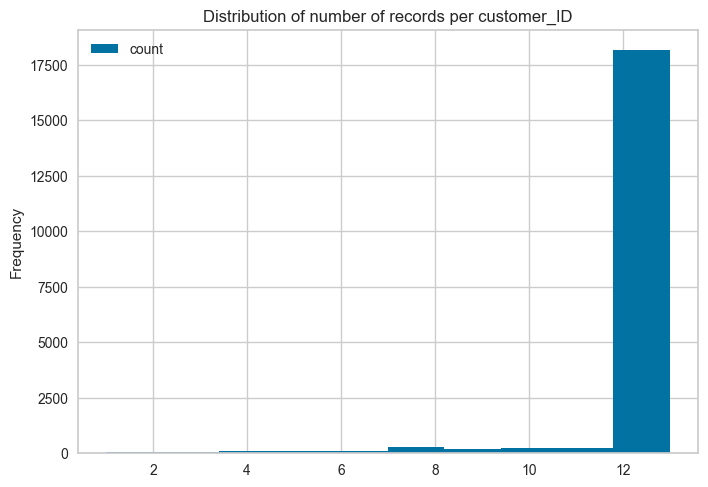

In [45]:
# calculate the number of records per customer_ID
records_per_cust = train_rndm_sample.groupby(
    'customer_ID').size().reset_index().rename(columns={
        0: 'count'
    }).sort_values(by='count', ascending=False)

# plot the distribution of number of records per customer_ID
records_per_cust.plot(
    kind='hist', title='Distribution of number of records per customer_ID');


In [51]:
s = ClassificationExperiment()
s.setup(data=train_rndm_sample, target='target', normalize=True, session_id=123, fold_strategy='timeseries', fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(246783, 194)"
4,Transformed data shape,"(336975, 227)"
5,Transformed train set shape,"(262940, 227)"
6,Transformed test set shape,"(74035, 227)"
7,Ordinal features,4
8,Numeric features,180
9,Date features,1


In [52]:
best = s.compare_models(include=['knn', 'xgboost', 'nb', 'qda', 'dt','lr', 'dummy'])

In [53]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

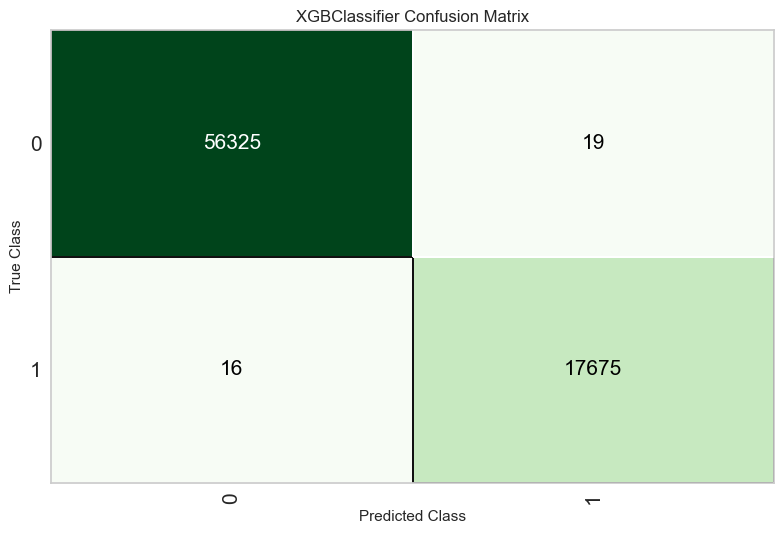

In [54]:
s.plot_model(best, plot = 'confusion_matrix')

In [55]:
pd.DataFrame(s.pull()).sort_values('F1', ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9745,0.9923,0.9479,0.9459,0.9469,0.9301,0.9301,12.389
lr,Logistic Regression,0.9733,0.9919,0.9530,0.9399,0.9461,0.9284,0.9287,3.691
dt,Decision Tree Classifier,0.9625,0.9501,0.9263,0.9194,0.9228,0.8980,0.8981,1.731
nb,Naive Bayes,0.9390,0.9620,0.9463,0.8372,0.8862,0.8452,0.8499,1.045
qda,Quadratic Discriminant Analysis,0.9453,0.9673,0.8407,0.9070,0.8636,0.8314,0.8376,2.924
knn,K Neighbors Classifier,0.9179,0.9709,0.9510,0.7690,0.8493,0.7941,0.8033,12.572
dummy,Dummy Classifier,0.7614,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.105
